# Quantum Optimal Control through Reinforcement Learning using TD3 on fidelity
### Preparation of the 3 qubit Greenberger–Horne–Zeilinger state (GHZ state)

In this notebook we address the task of creating the GHZ state $\frac{|000\rangle +|111\rangle}{\sqrt{2}}$ by optimising on the fidelity

In [1]:
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
from matplotlib import pyplot as plt

from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer
import numpy as np
import qiskit.quantum_info as qi
from math import pi
import math
from qiskit.quantum_info import Statevector, Operator,  DensityMatrix, state_fidelity
import itertools
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(1, '../src/')
from utils.functions import *
from models.models_rl import *

import random

random.seed(10)

In this cell, we define the quantum circuit designed to prepare the target GHZ state. You can also modify the target state and the initial state directly within this cell, allowing for flexibility in the setup. <br />

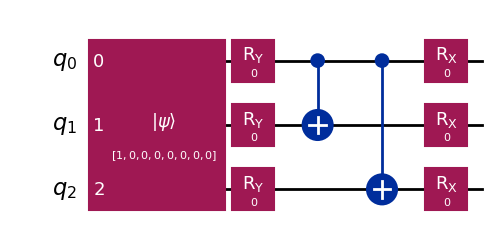

In [2]:
def create_controlled_ghz_circuit(thetas, initial_state):
  
    circ = QuantumCircuit(3)
    # Initialize qubits with the specified state
    circ.initialize(initial_state, [0,1,2])
    
    circ.ry(thetas[0,0], 0)
    circ.ry(thetas[0,1], 1)
    circ.ry(thetas[0,2], 2)
    circ.cx(0, 1)
    circ.cx(0, 2)
    circ.rx(thetas[0,3], 0)
    circ.rx(thetas[0,4], 1)
    circ.rx(thetas[0,5], 2)

    return circ
target_state = np.array([1 , 0, 0, 0, 0, 0, 0, 1])/np.sqrt(2)
initial_state = np.array([1, 0, 0, 0, 0, 0, 0, 0])
n_thetas = 6 #Number of parameters

ghz_visualization = create_controlled_ghz_circuit(np.zeros(n_thetas)[np.newaxis,:],initial_state)
ghz_visualization.draw('mpl')

We define the function to optimise

In [3]:
ghz_contr_circuit = create_controlled_ghz_circuit
def target_function(new_sample):
    _, new_fid_real, _ = get_expectation_values(ghz_contr_circuit, new_sample[np.newaxis,:],initial_state, target_state) #Get the real values

    return -new_fid_real

In [4]:
# Train the model
n_total_timesteps = 200
n_run = 10

params = {'lr': 0.0000001,
          'batch_size':5,
          'gamma':0.99,  
          'n_run':n_run,
          'n_total_timesteps': n_total_timesteps,
          'noise_std':0.01  ,
           'n_epochs': 20,
          }

metrics = {
    'best_fidelity_runs': np.zeros(n_run),
    'history_best_fidelity_runs': np.zeros((n_run, n_total_timesteps)),
    'value_losses_runs':np.zeros((n_run,n_total_timesteps)),
    'best_thetas_runs': np.zeros((n_run,n_thetas))
    }


for iter_run in range(n_run):
    print('run',iter_run+1)
    # Create the environment
    env = DummyVecEnv([lambda: OptimizationEnv(target_function=target_function, num_thetas=n_thetas)])
    metrics_callback = MetricsCallback()

   # Define the noise for exploration used in TD3
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=params['noise_std']* np.ones(n_actions))

    # Create the model
    model = TD3(
        CustomTD3Policy, 
        env,
        action_noise=action_noise,
        verbose=1,
        learning_rate=params['lr'],  
        batch_size=params['batch_size'],  # Minibatch size for each gradient update
        gamma=params['gamma'],  # Discount factor
    )


    model.learn(total_timesteps=n_total_timesteps, callback=metrics_callback )

    X_train = np.array(env.envs[0].states) #Thetas
    y_train = np.abs(env.envs[0].rewards) #Fidelity
    best_thetas = env.envs[0].best_thetas
    best_fidelity = env.envs[0].best_value

    metrics['best_fidelity_runs'][iter_run] = np.abs((env.envs[0]).history[-1]) 
    metrics['history_best_fidelity_runs'][iter_run,:] = np.abs(env.envs[0].history)
    metrics['value_losses_runs'][iter_run] = metrics_callback.value_losses
    metrics['best_thetas_runs'][iter_run,:] = best_thetas



run 1
Using cpu device
---------------------------
| time/              |    |
|    episodes        | 4  |
|    fps             | 32 |
|    time_elapsed    | 0  |
|    total_timesteps | 4  |
---------------------------
---------------------------
| time/              |    |
|    episodes        | 8  |
|    fps             | 34 |
|    time_elapsed    | 0  |
|    total_timesteps | 8  |
---------------------------
---------------------------
| time/              |    |
|    episodes        | 12 |
|    fps             | 32 |
|    time_elapsed    | 0  |
|    total_timesteps | 12 |
---------------------------
---------------------------
| time/              |    |
|    episodes        | 16 |
|    fps             | 33 |
|    time_elapsed    | 0  |
|    total_timesteps | 16 |
---------------------------
---------------------------
| time/              |    |
|    episodes        | 20 |
|    fps             | 33 |
|    time_elapsed    | 0  |
|    total_timesteps | 20 |
-------------------------

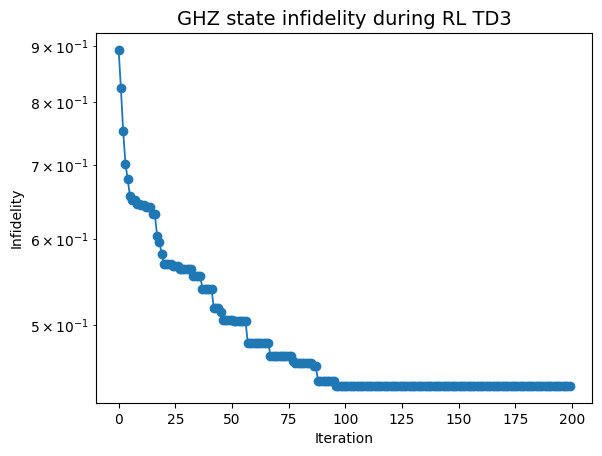

Mean best infidelity:  0.4402561779849734


In [5]:
plt.plot(np.arange(n_total_timesteps),1-np.mean(metrics['history_best_fidelity_runs'],0),'-o', linewidth=1.3)
plt.ylabel('Infidelity')
plt.xlabel('Iteration')
plt.yscale('log')
plt.title('GHZ state infidelity during RL TD3', size=14)
plt.show()
print('Mean best infidelity: ', 1-np.mean(metrics['best_fidelity_runs']))

In [6]:
# Test the model
obs = env.reset()
action, _ = model.predict(obs, deterministic=True)
print(f'Best angles: {action}')
print(f'Target function value: {1 - np.abs(target_function(action[0]))}')


Best angles: [[2.722209  3.0237653 3.0358064 3.3826127 3.4962142 3.306935 ]]
Target function value: 0.9877099792661438


In [7]:
data_plot = {   'history_best_fidelity_runs':metrics['history_best_fidelity_runs'],
                'best_thetas_runs': metrics['best_thetas_runs'],
                'best_fidelity_runs':metrics['best_fidelity_runs'],
            } 
if True:
    with open("../results/qoc/results_3ghz_td3.json", "w") as outfile: 
        json.dump(data_plot, outfile, cls=CustomEncoder)

Optionally: Track metrics and parameters in MLflow

In [8]:
import mlflow
#Metrics resume
metrics_reg= {
    'mean_infidelity_runs': 1- np.mean(metrics['best_fidelity_runs']),
    'std_infidelity_runs': np.std(metrics['best_fidelity_runs']),
        }

params['size_final_dataset'] = y_train.shape[0]


mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("QOC_3GHZ")

with mlflow.start_run(run_name='3GHZ_RL_TD3'):

    mlflow.log_params(params)
    mlflow.log_metrics(metrics_reg)
    
    

2024/09/21 11:22:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run GHZ_RL_TD3 at: http://127.0.0.1:8080/#/experiments/126759745047636218/runs/f63c3288f00049a0843471042ddaf86f.
2024/09/21 11:22:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/126759745047636218.
